In [49]:
# %%writefile Ind_PSY.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import matplotlib.pyplot as plt


import Analysis_Funs as af

import talib
# import base.JuUnits as ju

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class PSY(Ind_Model_Base.Ind_Model):
    """心理线（PSY）
    """
    optimum_param={'valid':False, 'main':'feature_PSY_CONTINUITY_NEG_ABS', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'PSY', frequence)
        self.renko_objs={}
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'PSY_timeperiod':22, 'PSY_MA':10}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
        def feature(item_df):
            direct = np.sign(item_df['PSY'] - item_df['PSYMA'])
            return af.timeline_event_continuity(direct.fillna(0))
        
        event_continuity = self.excute_for_multicode(self.ind_df,
                                         lambda x: pd.DataFrame(feature(x),
                                         index=x.index,
                                         columns=['feature_PSY_CONTINUITY_NEG_ABS']))
        self.ind_df = pd.concat([self.ind_df, event_continuity],axis=1)
        return event_continuity
        
    def kernel(self,dataframe,PSY_timeperiod, PSY_MA):
#         1.PSY=N日内上涨天数/N*100
#         2.PSYMA=PSY的M日简单移动平均
#         2.参数N设置为12日，参数M设置为6日
        close = dataframe.close
        direct = np.sign(close.diff())
        direct[direct<0] = 0
        PSY = direct.rolling(PSY_timeperiod).sum()
        PSY.name = 'PSY'
        PSY_df = pd.DataFrame(PSY)
        PSY_df['PSYMA']= PSY.rolling(PSY_timeperiod).apply(lambda x: x)

        return PSY_df

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        


Wall time: 98 ms


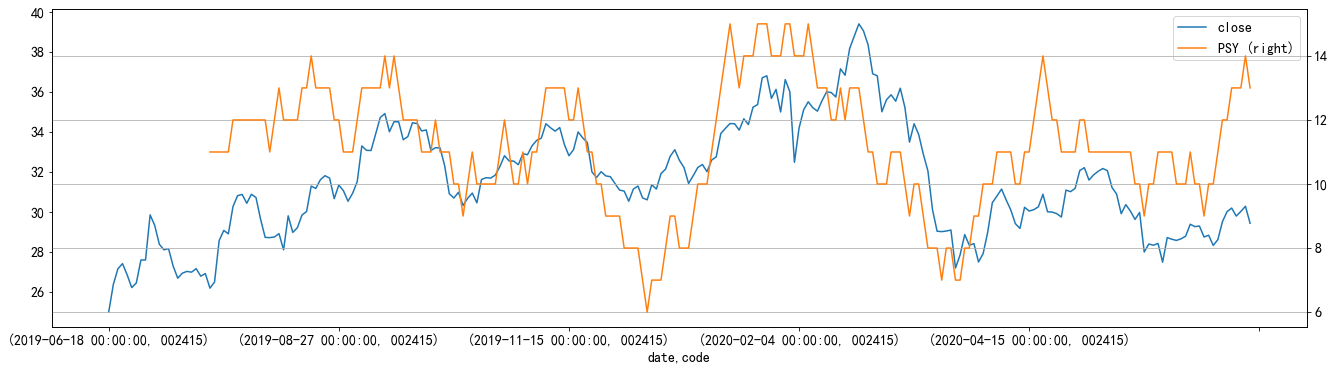

In [64]:
%%time
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
import tools.Sample_Tools as smpl
import Analysis_Funs as af
import base.JuUnits as ju
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib


data = smpl.get_data(['002415'],end='2020-06-29',gap=250).data
close = data.reset_index('code',drop=True).close

psy = PSY(data)
psy.fit()

pd.concat([data.close,psy.ind_df['PSY']],axis=1).plot(secondary_y=['PSY'],figsize=(1620/72,420/72))
plt.grid()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


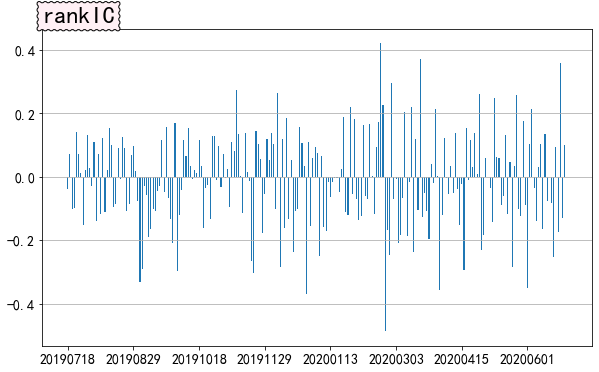

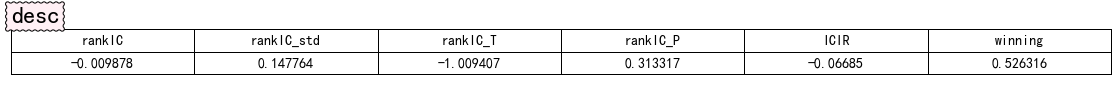

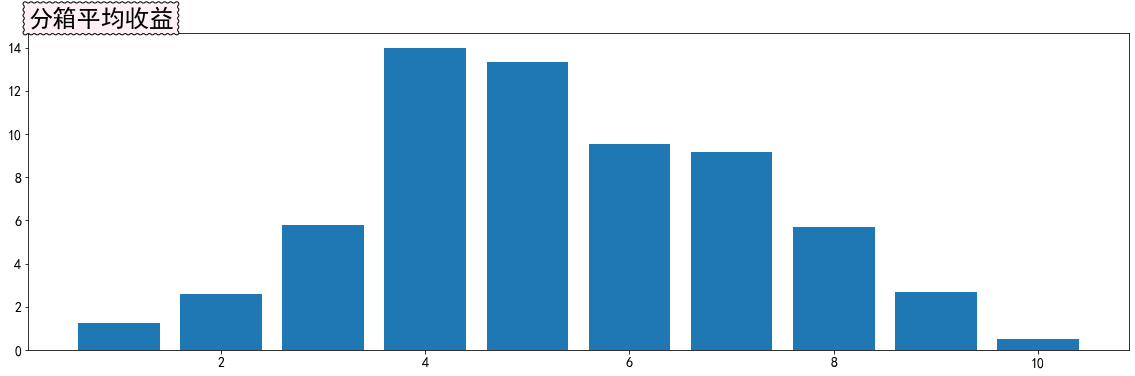

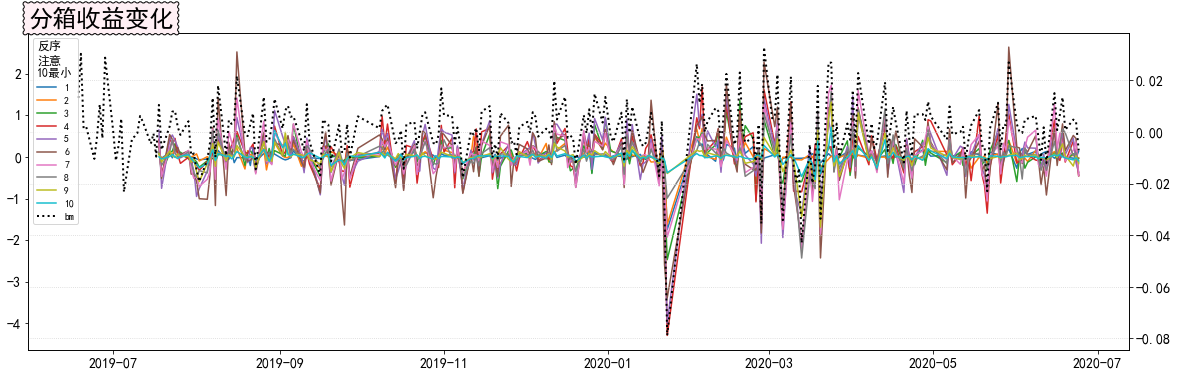

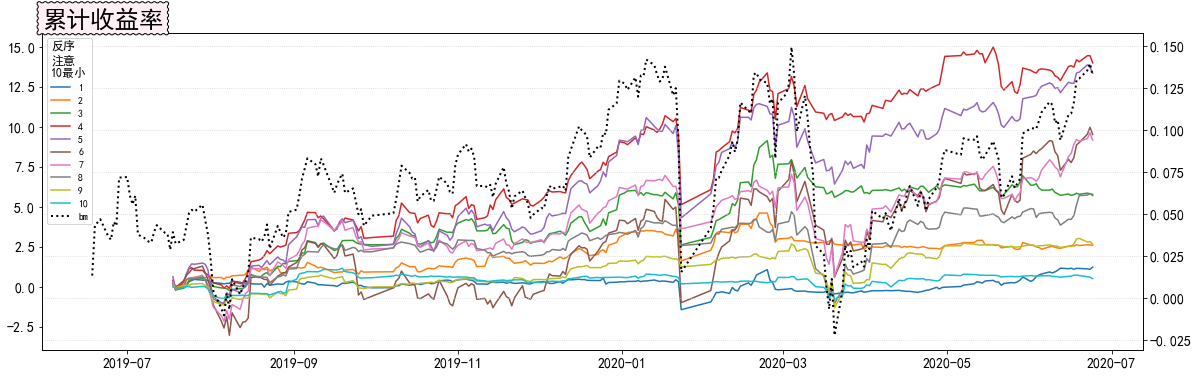

Wall time: 12.6 s


In [61]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

test1 = FactorTest(PSY, sample='沪深300', freq="d",end='2020-06-29',gap=250,only_main=True,neutralize={'enable':False,'static_mv':False},target_field='PSY')
test1.process()
test1.plot()